# 甲状腺組織画像の識別に関する研究
## 画像識別プログラム

## ライブラリ読み込み，ランダムシード固定

In [1]:
import random
import itertools
import copy

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import scipy

from utils.utils import ImageTransform, make_datapath_list, show_transform_img, show_wrong_img
from utils.dataset import ArrangeNumDataset
from models import InitResNet, InitEfficientNet, eval_net, train_net

%matplotlib inline

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### テスト用データの識別

In [2]:
data_path = "./data/"
label_list = ["Normal", "PTC HE", "UN", "fvptc", "FTC", "med", "poor", "und"]

train_list = make_datapath_list(data_path+"train")
test_list = make_datapath_list(data_path+"test")

train_dataset = ArrangeNumDataset(train_list, 
                                  label_list,
                                  phase="train",
                                  transform=ImageTransform(), 
                                  arrange="undersampling")
test_dataset = ArrangeNumDataset(test_list, 
                                 label_list,
                                 phase="val",
                                 transform=ImageTransform(), 
                                 arrange=None)

./data/train/**/*.tif
./data/test/**/*.tif


In [3]:
batch_size =32
num_workers = 8
only_fc = False    # 転移学習：True, FineTuning：False
pretrained = True  # 事前学習の有無
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)
print("len(train_dataset)", len(train_dataset))
print("len(test_dataset)", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers)

使用デバイス： cuda:0
len(train_dataset) 768
len(test_dataset) 1550


In [4]:
weights = torch.tensor(train_dataset.weights).float().cuda()
# weights = None
loss_fn=nn.CrossEntropyLoss(weight=weights)
print(loss_fn.weight)

tensor([8., 8., 8., 8., 8., 8., 8., 8.], device='cuda:0')


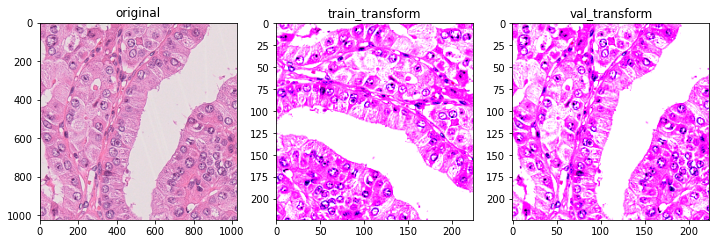

In [5]:
show_transform_img(test_list[100])

In [6]:
net = InitEfficientNet(only_fc=only_fc, pretrained=pretrained,
                       model_name="efficientnet-b3")

optimizer = optim.Adam(net.get_params_lr())

Loaded pretrained weights for efficientnet-b3


In [7]:
train_net(net(), train_loader, test_loader, optimizer=optimizer,
          epochs=30, device=device)
print("訓練完了")

100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


epoch:1/30  train_loss: 1.285  train_acc: 0.707  val_acc: 0.258


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch:2/30  train_loss: 0.321  train_acc: 0.902  val_acc: 0.331


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:3/30  train_loss: 0.159  train_acc: 0.954  val_acc: 0.404


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch:4/30  train_loss: 0.111  train_acc: 0.965  val_acc: 0.432


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:5/30  train_loss: 0.087  train_acc: 0.970  val_acc: 0.475


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch:6/30  train_loss: 0.064  train_acc: 0.977  val_acc: 0.510


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:7/30  train_loss: 0.059  train_acc: 0.979  val_acc: 0.550


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:8/30  train_loss: 0.059  train_acc: 0.983  val_acc: 0.561


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:9/30  train_loss: 0.034  train_acc: 0.990  val_acc: 0.617


100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


epoch:10/30  train_loss: 0.030  train_acc: 0.988  val_acc: 0.606


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:11/30  train_loss: 0.024  train_acc: 0.992  val_acc: 0.613


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:12/30  train_loss: 0.032  train_acc: 0.983  val_acc: 0.595


100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


epoch:13/30  train_loss: 0.051  train_acc: 0.982  val_acc: 0.586


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:14/30  train_loss: 0.027  train_acc: 0.992  val_acc: 0.608


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:15/30  train_loss: 0.030  train_acc: 0.992  val_acc: 0.610


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:16/30  train_loss: 0.022  train_acc: 0.992  val_acc: 0.602


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch:17/30  train_loss: 0.015  train_acc: 0.997  val_acc: 0.589


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:18/30  train_loss: 0.011  train_acc: 0.997  val_acc: 0.585


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:19/30  train_loss: 0.018  train_acc: 0.996  val_acc: 0.587


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:20/30  train_loss: 0.017  train_acc: 0.993  val_acc: 0.606


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:21/30  train_loss: 0.011  train_acc: 0.997  val_acc: 0.612


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:22/30  train_loss: 0.008  train_acc: 0.996  val_acc: 0.625


100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


epoch:23/30  train_loss: 0.008  train_acc: 0.999  val_acc: 0.638


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:24/30  train_loss: 0.013  train_acc: 0.993  val_acc: 0.626


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:25/30  train_loss: 0.006  train_acc: 1.000  val_acc: 0.610


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch:26/30  train_loss: 0.005  train_acc: 0.997  val_acc: 0.592


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:27/30  train_loss: 0.009  train_acc: 0.997  val_acc: 0.595


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch:28/30  train_loss: 0.003  train_acc: 1.000  val_acc: 0.594


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:29/30  train_loss: 0.003  train_acc: 1.000  val_acc: 0.601


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch:30/30  train_loss: 0.006  train_acc: 0.999  val_acc: 0.590
訓練完了


In [8]:
net = InitEfficientNet(model_name="efficientnet-b5")
load_path = "weight/last_weight.pth"
load_weights = torch.load(load_path)
net().load_state_dict(load_weights)

Loaded pretrained weights for efficientnet-b5


<All keys matched successfully>

In [8]:
ys, ypreds = eval_net(net(), test_loader, device=device)
ys = ys.cpu().numpy()
ypreds = ypreds.cpu().numpy()
print(accuracy_score(ys, ypreds))
print(confusion_matrix(ys, ypreds))
print(classification_report(ys, ypreds,
                            target_names=label_list,
                            digits=3))

0.5903225806451613
[[166   2  12   0   0   0   0   0]
 [ 19 366  48   1   2  15  42  14]
 [ 50  54 107   1   0   2   0   0]
 [ 18  35   1   5  22   0   0  72]
 [  0  15   2  18  17   3  98   2]
 [  0   0   0   0   0  21   0   0]
 [  0   0   0   0   0   0 100   0]
 [  1   1   0  67   0   4  14 133]]
              precision    recall  f1-score   support

      Normal      0.654     0.922     0.765       180
      PTC HE      0.774     0.722     0.747       507
          UN      0.629     0.500     0.557       214
       fvptc      0.054     0.033     0.041       153
         FTC      0.415     0.110     0.173       155
         med      0.467     1.000     0.636        21
        poor      0.394     1.000     0.565       100
         und      0.602     0.605     0.603       220

    accuracy                          0.590      1550
   macro avg      0.498     0.611     0.511      1550
weighted avg      0.580     0.590     0.562      1550



wrong_img_num: 1


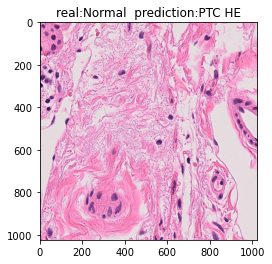

In [10]:
original_test_dataset = ArrangeNumDataset(test_list, label_list, phase="val")
show_wrong_img(original_test_dataset, ys, ypreds, indices=None, y=0, ypred=None)